In [385]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter



In [386]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta  

# Reflect Tables into SQLAlchemy ORM

In [387]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [388]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [389]:
# reflect an existing database into a new model
Base = automap_base()

In [390]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [391]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [392]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [393]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [394]:
# Query first row to see the columns and data in the first row of Measurment
first_row_measurment = session.query(Measurement).first()
first_row_measurment.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x247abacfa90>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0}

In [395]:
# Query first row to see the columns and data in the first row of Measurment
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x247aba6ea00>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [396]:

# Find the most recent date in the data set.
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all():    
    most_recent_date_string = row[0]

print(most_recent_date_string)    

2017-08-23


In [397]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.strptime('2017-08-23', '%Y-%m-%d')
print(most_recent_date)

# Calculate the date one year from the last date in data set.
yearfrom_most_recent_date = most_recent_date - timedelta(days=365)  
print(yearfrom_most_recent_date)


# Perform a query to retrieve the data and precipitation scores
#for row in session.query(Measurement.date,Measurement.prcp).filter(Measurement.date.between('1985-01-17', '2017-08-23'))
#     print(row)
dates = []
precipitations = []
for row in session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23'):    
    dates.append(row.date)
    precipitations.append(row.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column

measurements_df = pd.DataFrame(
    {'Date': dates,
     'Precipitation': precipitations
    }).set_index('Date')

# Sort the dataframe by date
measurements_df = measurements_df.sort_values(by=['Date'], ascending=True)
measurements_df


2017-08-23 00:00:00
2016-08-23 00:00:00


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


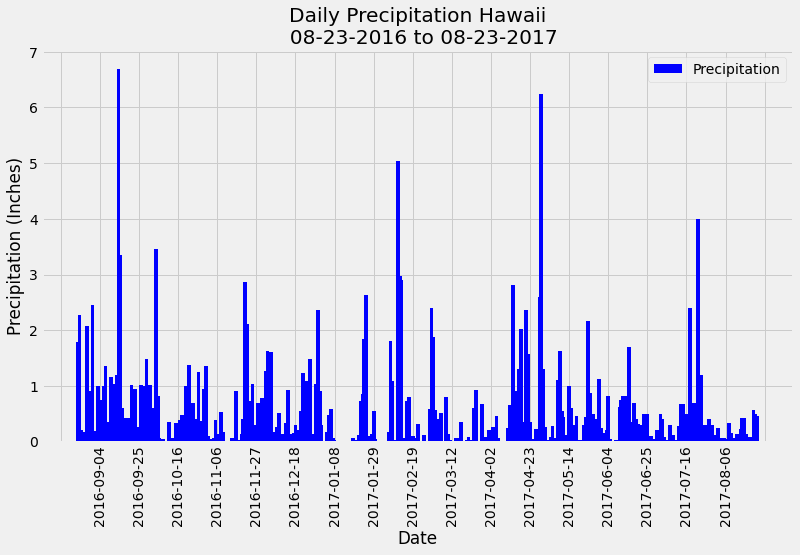

In [398]:
fig, ax = plt.subplots(figsize=(12, 8))

fig.subplots_adjust(bottom=0.2)

ax.bar(measurements_df.index.values, measurements_df['Precipitation'].values,  width=2, color='b')

ax.set(xlabel="Date", ylabel="Precipitation (Inches)",
       title="Daily Precipitation Hawaii\n  08-23-2016 to 08-23-2017")
ax.legend(['Precipitation'])
# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
plt.xticks(rotation='90')

plt.savefig('Images/figure1_dailyprecipitation_bar.png')
plt.show()


In [399]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [400]:
# Design a query to calculate the total number stations in the dataset
# {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2479bb5ca90>,
#  'longitude': -157.8168,
#  'id': 1,
#  'name': 'WAIKIKI 717.2, HI US',
#  'elevation': 3.0,
#  'station': 'USC00519397',
#  'latitude': 21.2716}

stations = []
    
for station in session.query(Station.station).distinct():
    stations.append(station)

count_stations = len(stations)
print(f'There are {count_stations} unique stations in Stations')


There are 9 unique stations in Stations


In [401]:
# Design a query to find the most active stations (i.e. what stations have the most rows (in Measurement table?)
# List the stations and the counts in descending order.
station_names = []
stations = []
station_counts = []
for s, m, count in session.query(Station, Measurement.station,func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station)).all():    
    station_names.append(s.name)
    stations.append(s.station)
    station_counts.append(int(count))

stations_measurements_df = pd.DataFrame(
    {'Count': station_counts,
     'Station Name': station_names,
     'Station':stations
    }).set_index('Station')

# Sort the dataframe by date
stations_measurements_df = stations_measurements_df.sort_values(by=["Count"], ascending=False)    
stations_measurements_df


,Count,Station Name
Station,,
USC00519281,2772,"WAIHEE 837.5, HI US"
USC00519397,2724,"WAIKIKI 717.2, HI US"
USC00513117,2709,"KANEOHE 838.1, HI US"
USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US"
USC00516128,2612,"MANOA LYON ARBO 785.2, HI US"
USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US"
USC00517948,1372,"PEARL CITY, HI US"
USC00518838,511,"UPPER WAHIAWA 874.3, HI US"


In [402]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_measurements_df.index[0]
print(most_active_station)

for min_tobs, max_tobs,avg_tobs in session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all():    
    print(f'Lowest temperature: {min_tobs} F')
    print(f'Highest temperature: {max_tobs} F')
    print(f'Average temperature: {round(avg_tobs,1)} F')
    

USC00519281
Lowest temperature: 54.0 F
Highest temperature: 85.0 F
Average temperature: 71.7 F


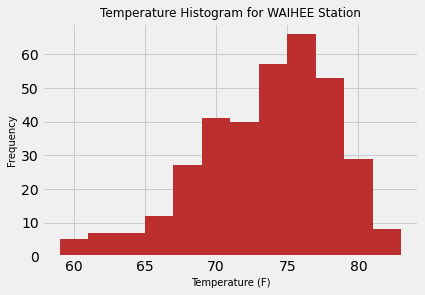

In [403]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = []
for row in session.query(Measurement).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23'):    
    temperatures.append(row.tobs)

plt.hist(temperatures, color='#bd2f2f',bins=12)
plt.title("Temperature Histogram for WAIHEE Station",fontsize=12)
plt.xlabel("Temperature (F)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.savefig("images/figure3_temperature_hist.png")

# Close session

In [404]:
# Close Session
session.close()